## Моделирование VaR портфеля
1. Работа с временными рядами
2. Различные подходы
   - Произведение одномерных распределений
   - Многомерные распределения
   - Копулы
3. Бектестирование
   - Тест Купика

In [ ]:
# # Раскомментировать, если не установлены 
# !pip install yfinance
# !pip install arch
# !pip install copulae
# # # https://copulae.readthedocs.io/en/latest/getting-started.html

In [2]:
import numpy as np
import pandas as pd
import scipy.stats
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns

import yfinance as yf
from arch import arch_model 

plt.style.use("bmh")
%config InlineBackend.figure_formats=["png"]

## Данные

Скачиваем котировки компаний Apple, HSBC и Toyota

In [3]:
data = yf.download("AAPL HSBC TM", start="2016-01-01", end="2021-01-01", group_by="ticker")

data.head()

[*********************100%***********************]  3 of 3 completed


HSBC                                                       \
                 Open       High        Low      Close  Adj Close   Volume   
Date                                                                         
2015-12-31  39.639999  39.680000  39.380001  39.470001  27.956379  1872500   
2016-01-04  38.299999  38.610001  38.060001  38.590000  27.333076  3553100   
2016-01-05  38.490002  38.610001  38.110001  38.500000  27.269335  1776500   
2016-01-06  37.150002  37.330002  36.990002  37.169998  26.327295  2970400   
2016-01-07  36.549999  36.869999  36.290001  36.389999  25.774830  3062900   

                 AAPL                                                         \
                 Open       High        Low      Close  Adj Close     Volume   
Date                                                                           
2015-12-31  26.752501  26.757500  26.205000  26.315001  24.164383  163649200   
2016-01-04  25.652500  26.342501  25.500000  26.337500  24.185043  270597600   
2016-01-05  26.437500  26.462500  25.602501  25.677500  23.578985  223164000   
2016-01-06  25.139999  25.592501  24.967501  25.174999  23.117548  273829600   
2016-01-07  24.670000  25.032499  24.107500  24.112499  22.141882  324377600   

                    TM                                                          
                  Open        High         Low       Close   Adj Close  Volume  
Date                                                                            
2015-12-31  123.349998  124.330002  122.650002  123.040001  118.950439  221000  
2016-01-04  121.519997  122.260002  120.169998  121.459999  117.422958  413500  
2016-01-05  121.540001  121.540001  120.160004  121.139999  117.113586  306400  
2016-01-06  118.570000  118.800003  117.760002  118.379997  114.445328  277600  
2016-01-07  116.080002  116.639999  115.459999  115.570000  111.728729  407500

In [4]:
prices = []

for ticker in data.columns.levels[0]:

    temp = data[ticker]['Close']
    temp.name = ticker
    prices.append(temp)

prices = pd.concat(prices, axis=1)

prices.head()

,HSBC,AAPL,TM
Date,,,
2015-12-31,39.470001,26.315001,123.040001
2016-01-04,38.590000,26.337500,121.459999
2016-01-05,38.500000,25.677500,121.139999
2016-01-06,37.169998,25.174999,118.379997
2016-01-07,36.389999,24.112499,115.570000


Строим график цен

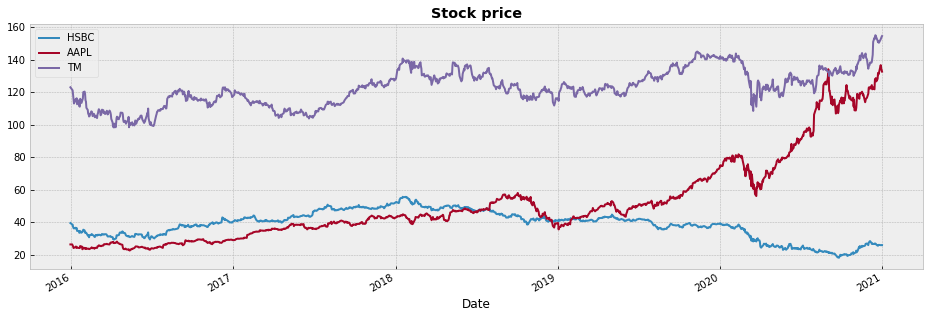

In [5]:
prices.plot(figsize=(16, 5))
plt.title("Stock price", weight="bold")
plt.show()

Строим графики доходностей

In [6]:
returns = 100*prices.pct_change().dropna()

returns.head()

,HSBC,AAPL,TM
Date,,,
2016-01-04,-2.229544,0.085499,-1.284137
2016-01-05,-0.233221,-2.505932,-0.263461
2016-01-06,-3.454550,-1.956968,-2.278357
2016-01-07,-2.098463,-4.220457,-2.373710
2016-01-08,-0.659516,0.528774,-2.171846


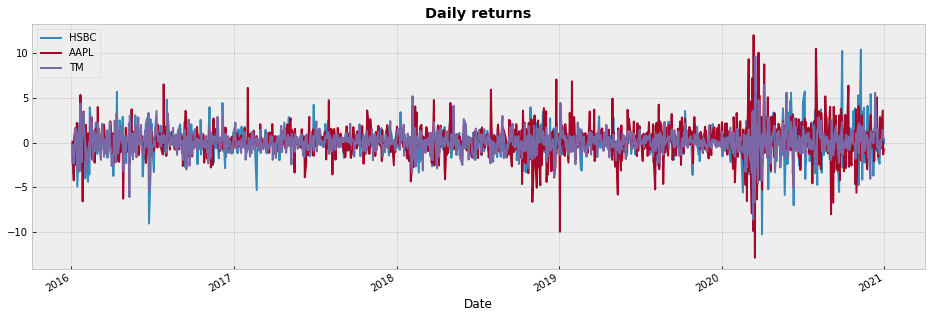

In [7]:
returns.plot(figsize=(16, 5))
plt.title("Daily returns", weight="bold")
plt.show()

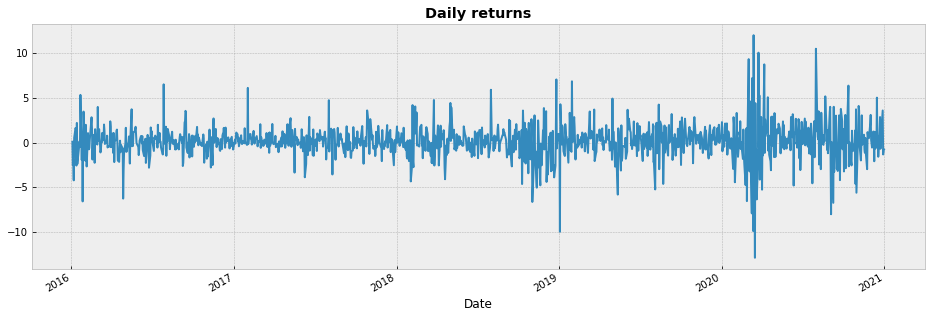

In [9]:
ret = returns['AAPL']

ret.plot(figsize=(16, 5))
plt.title("Daily returns", weight="bold")
plt.show()

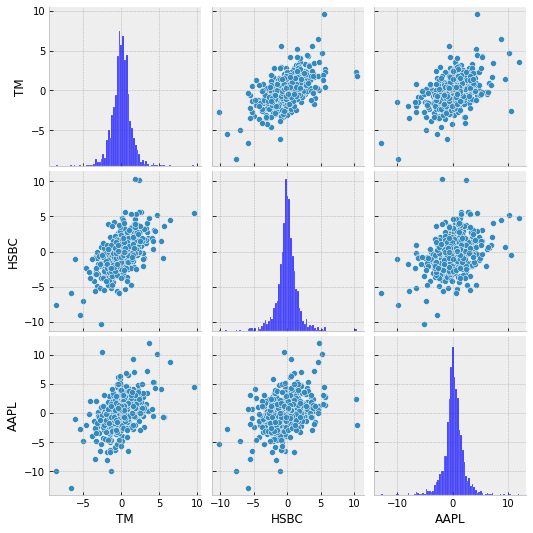

In [83]:
sns.pairplot(returns)

plt.show()

Возьмем функции для моделирования VaR различными способами с предыдущего семинара

In [8]:
def calculate_var_HS(returns, alpha):
    
    return returns.quantile(alpha)


def calculate_var_gennorm(returns, alpha):
    beta, loc, scale = scipy.stats.gennorm.fit(returns)
    
    return scipy.stats.gennorm.ppf(alpha, beta, loc, scale)


def calculate_var_garch(returns, alpha):
    
    scaling_const = 10.0 / returns.std()

    dist = 'skewstudent'
    am = arch_model(scaling_const * returns,
                    mean='HARX', lags=1, # mean = Constant, ARX, HARX + the number of lags
                    vol='Garch', p=1, o=1, q=1, # vol = Garch, EGARCH, HARCH + the number of lags
                    dist=dist) # dist = Normal, t, skewstudent, ged

    res = am.fit(update_freq=0, disp='off')

    forecasts = res.forecast(horizon=1, reindex=False)

    cond_mean = float(forecasts.mean.iloc[-1])
    cond_var = float(forecasts.variance.iloc[-1])

    if dist == 'Normal':
        q = am.distribution.ppf(alpha)
    elif dist == 't' or dist == 'ged':
        q = am.distribution.ppf(alpha, res.params[-1:])
    elif dist == 'skewstudent':
        q = am.distribution.ppf(alpha, res.params[-2:])

    return_garch_forecast = cond_mean / scaling_const
    VaR_garch_forecast = (cond_mean + np.sqrt(cond_var) * q) / scaling_const

    return return_garch_forecast, VaR_garch_forecast

In [9]:
ret = returns['AAPL']

returns.columns

Index(['TM', 'HSBC', 'AAPL'], dtype='object')

In [10]:
alpha = 0.01

T = len(ret)
T_start = 100
estimation_window = 250
testing_window = T - estimation_window

VaR_curve_HS = []
VaR_curve_gennorm = []
VaR_curve_garch = []
forecast_garch = []

for t in range(estimation_window+T_start, T):
    
    current_estimation_sample = ret[t-estimation_window:t]

    VaR_curve_HS.append(calculate_var_HS(current_estimation_sample, alpha))
    VaR_curve_gennorm.append(calculate_var_gennorm(current_estimation_sample, alpha))
    
    return_garch_forecast, VaR_garch_forecast = calculate_var_garch(current_estimation_sample, alpha)
    forecast_garch.append(return_garch_forecast)
    VaR_curve_garch.append(VaR_garch_forecast)
    
VaR_curve_HS = pd.Series(VaR_curve_HS, index=ret[estimation_window+T_start:].index)
VaR_curve_gennorm = pd.Series(VaR_curve_gennorm, index=ret[estimation_window+T_start:].index)
VaR_curve_garch = pd.Series(VaR_curve_garch, index=ret[estimation_window+T_start:].index)
forecast_garch = pd.Series(forecast_garch, index=ret[estimation_window+T_start:].index)

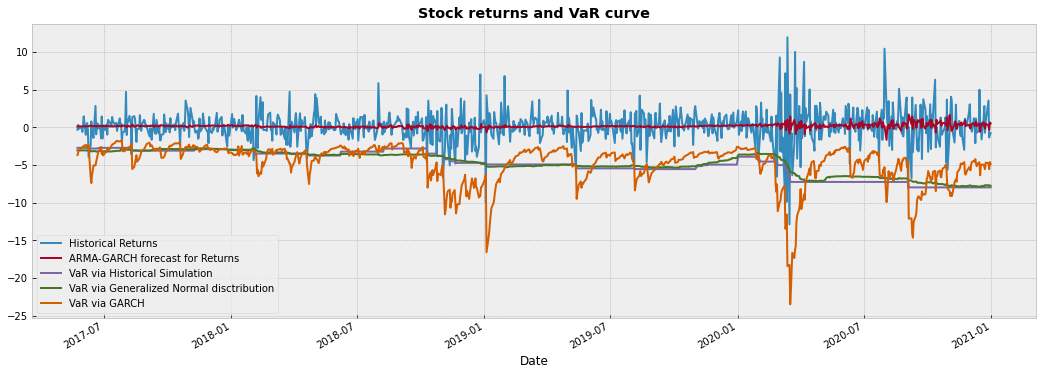

In [11]:
fig = plt.figure()
fig.set_size_inches(18,6)
ret[estimation_window+T_start:].plot()
forecast_garch.plot()
VaR_curve_HS.plot()
VaR_curve_gennorm.plot()
VaR_curve_garch.plot()

plt.title("Stock returns and VaR curve", weight="bold")

plt.legend(['Historical Returns',
            'ARMA-GARCH forecast for Returns',
            'VaR via Historical Simulation',
            'VaR via Generalized Normal disctribution',
           'VaR via GARCH'])
plt.show()

Таким образом, мы для каждого способа моделирования получили кривую VaR

Вопросы:
- Какой способ подсчета VaR выбрать? 
- Как моделировать доходность портфеля из нескольких активов?

Для выбора подходящей модели будем использовать тест Купика, который сравнивает модельную и реальную частоту пробоев.

[Overview of VaR Backtesting](https://www.mathworks.com/help/risk/overview-of-var-backtesting.html)

In [12]:
def kupiec_test(VaR_curve, actual_returns, pp=0.1):
    
    T = len(actual_returns)
    K = (actual_returns < VaR_curve).sum()
    alpha_0 = K / T
    
    S = -2*np.log((1-alpha)**(T-K) * alpha**K) + 2*np.log((1-alpha_0)**(T-K) * alpha_0**K)
    p_value = 1 - scipy.stats.chi2.cdf(S, df=1)
        
    if np.isnan(p_value):
        p_value = 0.
        
    print('Количество наблюдений:', T)
    print('Желаемый уровень пробитий: {:.1f}%'.format(alpha*100))
    print('Уровень пробитий в модели: {:.2f}%'.format(alpha_0*100))
        
    print('\np-value теста: {:.3f}'.format(p_value))
    if p_value > pp:
        print("""\nПри уровне значимости {:.0f}% гипотеза гипотеза о
том, что эмпирическая и модельная частоты превышений фактическими
убытками границы VaR равны, НЕ ОТВЕРГАЕТСЯ""".format(pp*100))
    else:
        print("""\nПри уровне значимости {:.1f}% гипотеза гипотеза о
том, что эмпирическая и модельная частоты превышений фактическими
убытками границы VaR равны, отвергается""".format(pp*100))

In [13]:
kupiec_test(VaR_curve_gennorm, ret[estimation_window+T_start:])

Количество наблюдений: 909
Желаемый уровень пробитий: 1.0%
Уровень пробитий в модели: 2.09%

p-value теста: 0.004

При уровне значимости 10.0% гипотеза гипотеза о
том, что эмпирическая и модельная частоты превышений фактическими
убытками границы VaR равны, отвергается


In [14]:
kupiec_test(VaR_curve_garch, ret[estimation_window+T_start:])

Количество наблюдений: 909
Желаемый уровень пробитий: 1.0%
Уровень пробитий в модели: 1.87%

p-value теста: 0.019

При уровне значимости 10.0% гипотеза гипотеза о
том, что эмпирическая и модельная частоты превышений фактическими
убытками границы VaR равны, отвергается


--------
Теперь будем моделировать совместное распределение длходностей активов, чтобы подсчитать Value-at-Risk всего портфеля.

Сначала посмотрим на историческое распределение доходностей двух акций

<Figure size 432x432 with 0 Axes>

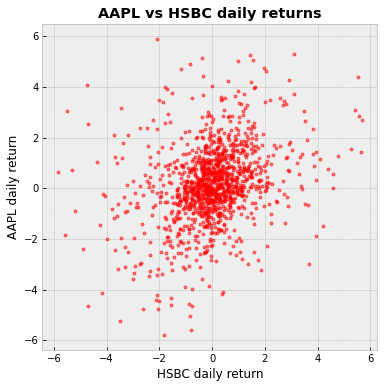

In [18]:
idx = (returns['HSBC'] > -6) & (returns['HSBC'] < 6)
idx = idx & (returns['AAPL'] > -6) & (returns['AAPL'] < 6)

x = returns.loc[idx, 'HSBC']
y = returns.loc[idx, 'AAPL']

fig = plt.figure()
fig.set_size_inches(6,6)

fig = plt.figure()
fig.set_size_inches(6,6)

plt.plot(x, y, "r.", alpha=0.5)
plt.xlabel("HSBC daily return")
plt.ylabel("AAPL daily return")
plt.title("AAPL vs HSBC daily returns", weight="bold")
plt.show()

Мы можем смоделировать частные распределения с помощью уже известных нам распределений, например Стьюдента

In [19]:
n_samples = 10 ** 5

return_simulations = {}

# для каждой акции оцениваем одномерное распределение, а потом сэмплируем из него новые псевдо-наблюдения
for col in returns.columns:
    t_df, t_mean, t_sigma = scipy.stats.t.fit(returns[col])
    return_simulations[col] = scipy.stats.t.rvs(t_df, loc=t_mean, scale=t_sigma, size=n_samples, random_state=42)
    
return_simulations = pd.DataFrame(return_simulations)

In [21]:
return_simulations.head()

,TM,HSBC,AAPL
0,0.551604,0.572316,0.828448
1,-0.915828,-0.990065,-1.034024
2,1.191358,1.169040,1.550052
3,-0.677627,-0.824723,-0.825355
4,0.767927,1.391806,1.693273


In [22]:
returns.head()

,TM,HSBC,AAPL
Date,,,
2016-01-04,-1.284137,-2.229544,0.085499
2016-01-05,-0.263461,-0.233221,-2.505932
2016-01-06,-2.278357,-3.454550,-1.956968
2016-01-07,-2.373710,-2.098463,-4.220457
2016-01-08,-2.171846,-0.659516,0.528774


In [23]:
np.cov(returns.values, rowvar=False)

array([[1.67509752, 1.10770585, 1.05170858],
       [1.10770585, 2.55957663, 1.1365302 ],
       [1.05170858, 1.1365302 , 3.61669758]])

In [24]:
np.cov(return_simulations.values, rowvar=False)

array([[1.74411894e+00, 1.96677094e-02, 2.19037884e-03],
       [1.96677094e-02, 5.25344866e+00, 6.26508361e-02],
       [2.19037884e-03, 6.26508361e-02, 5.23261582e+00]])

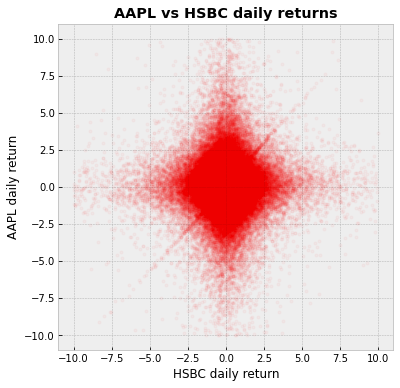

In [25]:
idx = (return_simulations['HSBC'] > -10) & (return_simulations['HSBC'] < 10)
idx = idx & (return_simulations['AAPL'] > -10) & (return_simulations['AAPL'] < 10)

x = return_simulations.loc[idx, 'HSBC']
y = return_simulations.loc[idx, 'AAPL']

fig = plt.figure()
fig.set_size_inches(6,6)

plt.plot(x, y, "r.", alpha=0.03)
plt.xlabel("HSBC daily return")
plt.ylabel("AAPL daily return")
plt.title("AAPL vs HSBC daily returns", weight="bold")
plt.show()

In [113]:
w = np.ones(shape=(returns.shape[1],)) / returns.shape[1]

# w = 1 / prices.iloc[0]
# w = w / w.sum()
portfolio_real_returns = np.dot(returns.values, w)

print(w)
portfolio_real_returns

[0.33333333 0.33333333 0.33333333]


array([-1.14272723, -1.00087149, -2.56329197, ..., -0.32087355,
        0.03373333, -0.19146869])

/Users/elizaveta/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


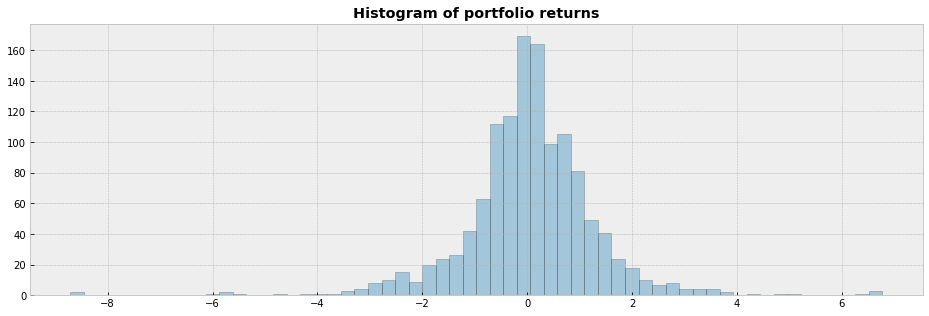

In [114]:
fig = plt.figure(figsize=(16, 5))

sns.distplot(portfolio_real_returns, hist=True, kde=False, 
             bins=60,
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})

plt.title("Histogram of portfolio returns", weight="bold")

plt.show()

## Произведение одномерных распределений

Попробуем смоделировать доходности каждого актива отделььно и затем перейти к доходности портфеля с равномерными весами

In [117]:
import scipy.stats as ss

In [115]:
n_samples = 10 ** 4

return_simulations = {}

# для каждой акции оцениваем одномерное распределение, а потом сэмплируем из него новые псевдо-наблюдения
for col in returns.columns:
    t_df, t_mean, t_sigma = ss.t.fit(returns[col])
    return_simulations[col] = ss.t.rvs(t_df, loc=t_mean, scale=t_sigma, size=n_samples, random_state=42)
    
return_simulations = pd.DataFrame(return_simulations)

return_simulations.shape

(10000, 3)

/Users/elizaveta/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


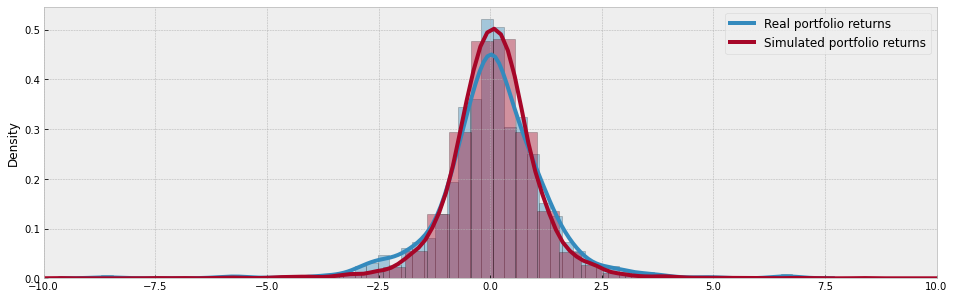

In [116]:
portfolio_simulated_returns = np.dot(return_simulations.values, w)

fig = plt.figure(figsize=(16, 5))

sns.distplot(portfolio_real_returns, hist=True, kde=True, 
             bins=60,
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})

sns.distplot(portfolio_simulated_returns, hist=True, kde=True, 
             bins=60,
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})

plt.xlim((-10, 10))

plt.legend(['Real portfolio returns',
            'Simulated portfolio returns'], fontsize=12)
plt.show()

Однако здесь никак не учитываются корреляции между активами.

## Многомерные распределения

Один из способов это сделать -- использовать многомерные распределения, например, многомерное нормальное распределение

In [26]:
n_samples = 10 ** 5

# оцениваем параметры нормального распределения распределение
mean = np.mean(returns.values, axis=0)
cov = np.cov(returns.values, rowvar=False)

# а потом сэмплируем из него новые псевдо-наблюдения
return_simulations = scipy.stats.multivariate_normal.rvs(mean=mean, cov=cov, size=n_samples, random_state=42)

return_simulations = pd.DataFrame(return_simulations, columns=returns.columns)

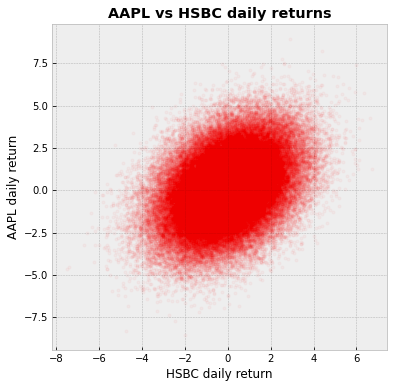

In [28]:
idx = (return_simulations['HSBC'] > -10) & (return_simulations['HSBC'] < 10)
idx = idx & (return_simulations['AAPL'] > -10) & (return_simulations['AAPL'] < 10)

x = return_simulations.loc[idx, 'HSBC']
y = return_simulations.loc[idx, 'AAPL']

fig = plt.figure()
fig.set_size_inches(6,6)

plt.plot(x, y, "r.", alpha=0.03)
plt.xlabel("HSBC daily return")
plt.ylabel("AAPL daily return")
plt.title("AAPL vs HSBC daily returns", weight="bold")
plt.show()

Посчитаем VaR для портфеля с одинаковыми весами

In [29]:
w = np.ones(shape=(returns.shape[1],)) / 3
w

array([0.33333333, 0.33333333, 0.33333333])

In [30]:
alpha = 0.05

In [31]:
# умножаем матрицу псевдо-наблюдений на вектор весов и получаем псевдо-наблюдения доходностей портфеля

portfolio_real_returns = np.dot(returns.values, w)
portfolio_simulated_returns = np.dot(return_simulations.values, w)

print(np.quantile(portfolio_real_returns, alpha))
print(np.quantile(portfolio_simulated_returns, alpha))

-1.940918992741036
-2.0293146157777207


Эмпирическая квантиль и квантиль многомерного нормального распределения похожи. Посмотрим на гистограмму распределения доходностей портфеля

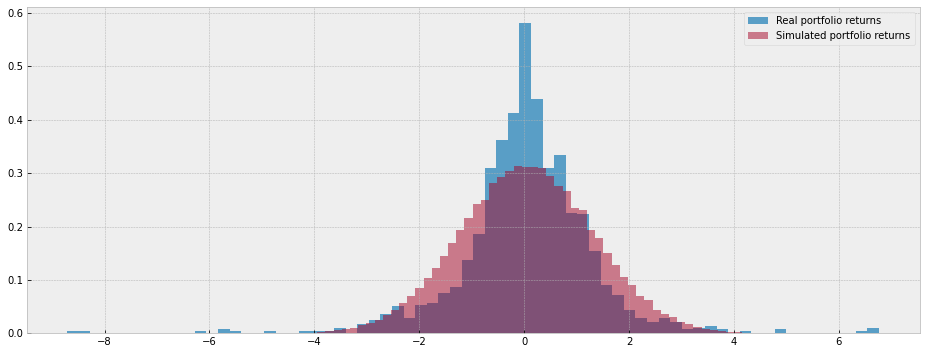

In [32]:
fig = plt.figure()
fig.set_size_inches(16,6)

plt.hist(portfolio_real_returns, bins=70, density=True, alpha=0.8, label='Real portfolio returns')
plt.hist(portfolio_simulated_returns, bins=70, density=True, alpha=0.5, label='Simulated portfolio returns')
plt.legend(loc='upper right')

Распределения сильно отличаются.

## Копулы

[Документация](https://copulae.readthedocs.io/en/latest/getting-started.html)

In [43]:
from copulae import NormalCopula, GaussianCopula, StudentCopula

Сначала моделируем частные распределения активов, например, с помощью распределения Стьюдента

In [33]:
cdfs = returns.copy()
distribution_params = {}

for col in cdfs.columns:
    t_df, t_mean, t_sigma = scipy.stats.t.fit(cdfs[col])
    distribution_params[col] = (t_df, t_mean, t_sigma)
    cdfs[col] = scipy.stats.t.cdf(cdfs[col], df=t_df, loc=t_mean, scale=t_sigma)

In [34]:
cdfs

,TM,HSBC,AAPL
Date,,,
2016-01-04,0.107483,0.053816,0.475590
2016-01-05,0.375183,0.404653,0.052688
2016-01-06,0.032455,0.022005,0.080463
2016-01-07,0.029242,0.060255,0.018376
2016-01-08,0.036551,0.261191,0.621437
...,...,...,...
2020-12-24,0.303342,0.527580,0.692261
2020-12-28,0.899749,0.232134,0.968311
2020-12-29,0.679413,0.450345,0.137888


In [35]:
returns

,TM,HSBC,AAPL
Date,,,
2016-01-04,-1.284137,-2.229544,0.085499
2016-01-05,-0.263461,-0.233221,-2.505932
2016-01-06,-2.278357,-3.454550,-1.956968
2016-01-07,-2.373710,-2.098463,-4.220457
2016-01-08,-2.171846,-0.659516,0.528774
...,...,...,...
2020-12-24,-0.456472,0.076829,0.771224
2020-12-28,1.415568,-0.767750,3.576571
2020-12-29,0.484921,-0.116057,-1.331485


In [36]:
distribution_params

{'TM': (3.5730808580293143, 0.03851023689618152, 0.8787253097213166),
 'HSBC': (2.4457295614138572, 0.00808737078287405, 0.8986740790094236),
 'AAPL': (2.5303026344596873, 0.15810489310334794, 1.0762545711812446)}

Посмотрим как выглядят доходности и распределение их квантилей

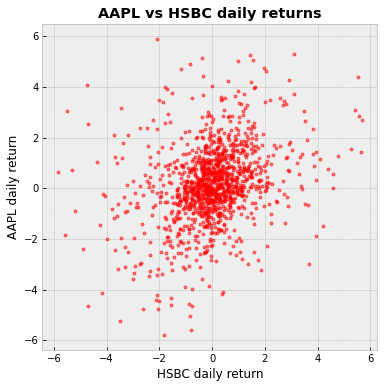

In [37]:
idx = (returns['HSBC'] > -6) & (returns['HSBC'] < 6)
idx = idx & (returns['AAPL'] > -6) & (returns['AAPL'] < 6)

x = returns.loc[idx, 'HSBC']
y = returns.loc[idx, 'AAPL']

fig = plt.figure()
fig.set_size_inches(6,6)

plt.plot(x, y, "r.", alpha=0.5)
plt.xlabel("HSBC daily return")
plt.ylabel("AAPL daily return")
plt.title("AAPL vs HSBC daily returns", weight="bold")
plt.show()

Распределение их квантилей

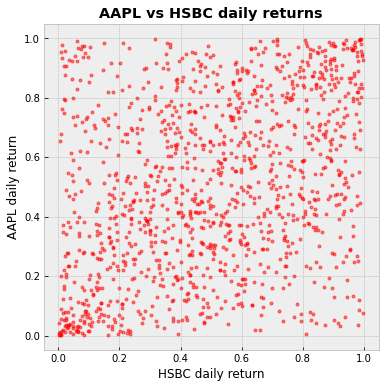

In [39]:
x = cdfs['HSBC']
y = cdfs['AAPL']

fig = plt.figure()
fig.set_size_inches(6,6)

plt.plot(x, y, "r.", alpha=0.5)
plt.xlabel("HSBC daily return")
plt.ylabel("AAPL daily return")
plt.title("AAPL vs HSBC daily returns", weight="bold")
plt.show()

In [40]:
returns.head()

,TM,HSBC,AAPL
Date,,,
2016-01-04,-1.284137,-2.229544,0.085499
2016-01-05,-0.263461,-0.233221,-2.505932
2016-01-06,-2.278357,-3.454550,-1.956968
2016-01-07,-2.373710,-2.098463,-4.220457
2016-01-08,-2.171846,-0.659516,0.528774


In [41]:
cdfs.head()

,TM,HSBC,AAPL
Date,,,
2016-01-04,0.107483,0.053816,0.475590
2016-01-05,0.375183,0.404653,0.052688
2016-01-06,0.032455,0.022005,0.080463
2016-01-07,0.029242,0.060255,0.018376
2016-01-08,0.036551,0.261191,0.621437


Оценим Нормальную копулу и посмотрим на ее описание

In [44]:
cop = NormalCopula(dim=3)
cop.fit(cdfs)

                TM         HSBC         AAPL
count  1259.000000  1259.000000  1259.000000
mean      0.500000     0.500000     0.500000
std       0.288561     0.288560     0.288561
min       0.000794     0.000794     0.000794
25%       0.250397     0.250397     0.250397
50%       0.500000     0.503571     0.500000
75%       0.749603     0.749603     0.749603
max       0.999206     0.999206     0.999206


In [45]:
cop.summary()

1.000000,0.512724,0.395753
0.512724,1.000000,0.365538
0.395753,0.365538,1.000000


Теперь мы можем сэмплировать частные квантили с помощью оцененной копулы, и можем построить их распределение

In [46]:
n_samples = 10 ** 5

copula_simulations = cop.random(n_samples, seed=42)

copula_simulations = pd.DataFrame(copula_simulations, columns=cdfs.columns)

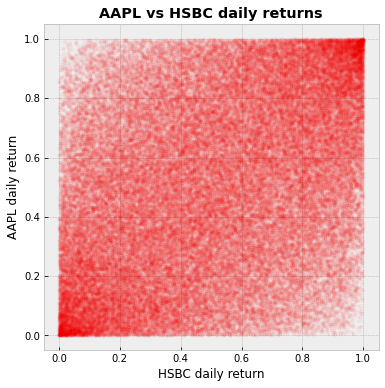

In [47]:
x = copula_simulations['HSBC']
y = copula_simulations['AAPL']

fig = plt.figure()
fig.set_size_inches(6,6)

plt.plot(x, y, "r.", alpha=0.03)
plt.xlabel("HSBC daily return")
plt.ylabel("AAPL daily return")
plt.title("AAPL vs HSBC daily returns", weight="bold")
plt.show()

Теперь вернемся от квантилей к доходностям с помощью inverse CDF и посмотрим на распределение сэмплов

In [48]:
return_simulations = copula_simulations.copy()

for col in cdfs.columns:
    t_df, t_mean, t_sigma = distribution_params[col]
    return_simulations[col] = scipy.stats.t.ppf(copula_simulations[col], df=t_df, loc=t_mean, scale=t_sigma)

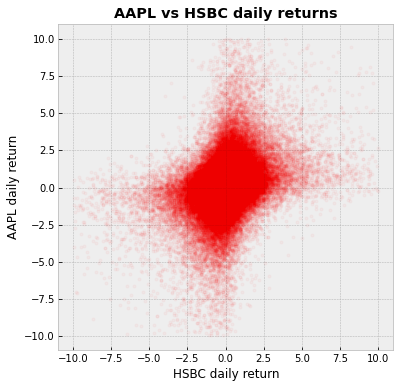

In [49]:
idx = (return_simulations['HSBC'] > -10) & (return_simulations['HSBC'] < 10)
idx = idx & (return_simulations['AAPL'] > -10) & (return_simulations['AAPL'] < 10)

x = return_simulations.loc[idx, 'HSBC']
y = return_simulations.loc[idx, 'AAPL']

fig = plt.figure()
fig.set_size_inches(6,6)

# fft_axes = fig.add_subplot(212)

plt.plot(x, y, "r.", alpha=0.03)
plt.xlabel("HSBC daily return")
plt.ylabel("AAPL daily return")
plt.title("AAPL vs HSBC daily returns", weight="bold")
plt.show()

Зависимость нелинейная. Посчитаем квантиль в данном случае, а затем посмотрим на гистограммы

In [50]:
portfolio_real_returns = np.dot(returns.values, w)
portfolio_simulated_returns = np.dot(return_simulations.values, w)

print(np.quantile(portfolio_real_returns, alpha))
print(np.quantile(portfolio_simulated_returns, alpha))

-1.940918992741036
-1.8611315867983644


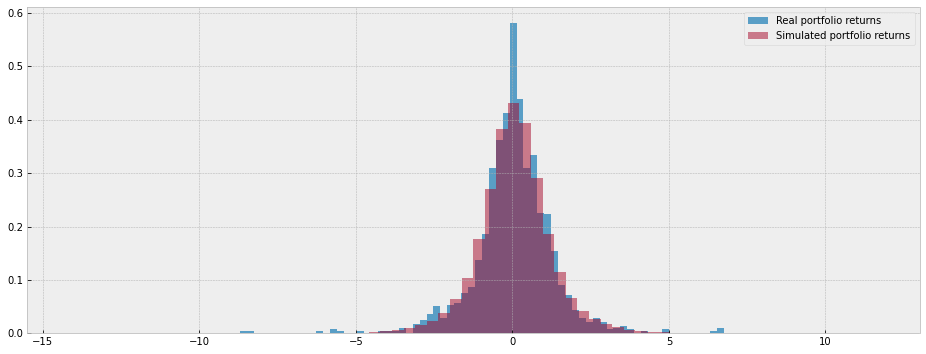

In [51]:
fig = plt.figure()
fig.set_size_inches(16,6)

plt.hist(portfolio_real_returns, bins=70, density=True, alpha=0.8, label='Real portfolio returns')
plt.hist(portfolio_simulated_returns[idx], bins=70, density=True, alpha=0.5, label='Simulated portfolio returns')
plt.legend(loc='upper right')
plt.show()

Выглядит лучше! Но мы и на этом не остановимся.


**Во-вервых**, можно использовать другие копулы и другие частные распределения

In [53]:
from copulae import ClaytonCopula, FrankCopula, GumbelCopula

In [57]:
univariate_dist = 'gennorm' # gennorm
cop = ClaytonCopula(dim=cdfs.shape[1])
n_samples = 10 ** 5

cdfs = returns.copy()
distribution_params = {}

for col in cdfs.columns:
    if univariate_dist == 't':
        t_df, t_mean, t_sigma = scipy.stats.t.fit(cdfs[col])
        distribution_params[col] = (t_df, t_mean, t_sigma)
        cdfs[col] = scipy.stats.t.cdf(cdfs[col], df=t_df, loc=t_mean, scale=t_sigma)
    else:
        beta, loc, scale = scipy.stats.gennorm.fit(cdfs[col])
        distribution_params[col] = (beta, loc, scale)
        cdfs[col] = scipy.stats.gennorm.cdf(cdfs[col], beta, loc, scale)

cop.fit(cdfs)

copula_simulations = cop.random(n_samples, seed=42)
copula_simulations = pd.DataFrame(copula_simulations, columns=cdfs.columns)

return_simulations = copula_simulations.copy()

for col in cdfs.columns:
    if univariate_dist == 't':
        t_df, t_mean, t_sigma = distribution_params[col]
        return_simulations[col] = scipy.stats.t.ppf(copula_simulations[col], df=t_df, loc=t_mean, scale=t_sigma)
    else:
        beta, loc, scale = distribution_params[col]
        return_simulations[col] = scipy.stats.gennorm.ppf(copula_simulations[col], beta, loc, scale)

                TM         HSBC         AAPL
count  1259.000000  1259.000000  1259.000000
mean      0.500000     0.500000     0.500000
std       0.288561     0.288560     0.288561
min       0.000794     0.000794     0.000794
25%       0.250397     0.250397     0.250397
50%       0.500000     0.503571     0.500000
75%       0.749603     0.749603     0.749603
max       0.999206     0.999206     0.999206


In [58]:
portfolio_real_returns = np.dot(returns.values, w)
portfolio_simulated_returns = np.dot(return_simulations.values, w)

print(np.quantile(portfolio_real_returns, alpha))
print(np.quantile(portfolio_simulated_returns, alpha))

-1.940918992741036
-1.9923847724239871


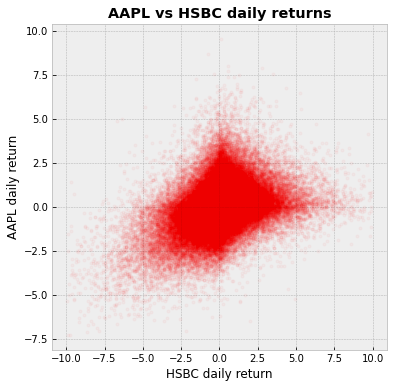

In [60]:
idx = (return_simulations['HSBC'] > -10) & (return_simulations['HSBC'] < 10)
idx = idx & (return_simulations['AAPL'] > -10) & (return_simulations['AAPL'] < 10)

x = return_simulations.loc[idx, 'AAPL']
y = return_simulations.loc[idx, 'TM']

fig = plt.figure()
fig.set_size_inches(6,6)

# fft_axes = fig.add_subplot(212)

plt.plot(x, y, "r.", alpha=0.03)
plt.xlabel("HSBC daily return")
plt.ylabel("AAPL daily return")
plt.title("AAPL vs HSBC daily returns", weight="bold")
plt.show()

Получилась другая зависимость

**Во-вторых**, можно использовать ARMA-GARCH для учета временной структуры доходностей

Для удобства напишем нужные нам функции

In [61]:
from arch import arch_model 

In [62]:
ret = returns.dropna()
dist = 'skewstudent'

def get_garch_residuals(ret, dist):

    scaling_const = 10.0 / ret.std()

    # объявляем GARCH модель
    am = arch_model(ret * scaling_const,
                    mean='HARX', lags=1, # mean = Constant, ARX, HARX + the number of lags
                    vol='Garch', p=1, o=0, q=1, # vol = Garch, EGARCH, HARCH + the number of lags
                    dist=dist) # dist = Normal, t, skewstudent, ged

    # фитим модель на данных
    res = am.fit(update_freq=0, disp='off')


    # сохраняем ее распределение
    if dist == 'Normal':
        cdf = am.distribution.cdf(res.resid.dropna())
    elif dist == 't' or dist == 'ged':
        cdf = am.distribution.cdf(res.resid.dropna(), res.params[-1:])
    elif dist == 'skewstudent':
        cdf = am.distribution.cdf(res.resid, res.params[-2:])

        
    return cdf, am, res, scaling_const


def make_garch_forecast(copula_simulation, dist, garch_object, garch_model, scaling_const):
    
    # делаем прогноз среднего и дисперсии
    forecasts = garch_object.forecast(horizon=1, reindex=False)

    cond_mean = float(forecasts.mean.iloc[-1])
    cond_var = float(forecasts.variance.iloc[-1])

    # получаем из сэплов квантили сэмплы доходностей
    if dist == 'Normal':
        q = garch_model.distribution.ppf(copula_simulation)
    elif dist == 't' or dist == 'ged':
        q = garch_model.distribution.ppf(copula_simulation, garch_object.params[-1:])
    elif dist == 'skewstudent':
        q = garch_model.distribution.ppf(copula_simulation, garch_object.params[-2:])

    # и по формуле считаем ВаР
    return (cond_mean + np.sqrt(cond_var) * q) / scaling_const

In [63]:
def make_copula_simulation(returns, copula_func, n_samples, univariate_dist, dist='skewstudent'):

    # объявляем копулу
    cop = copula_func(dim=returns.shape[1])

    cdfs = returns.copy()
    distribution_params = {}

    # моделируем частные распределения для каждой акции
    for col in cdfs.columns:
        if univariate_dist == 't':
            t_df, t_mean, t_sigma = scipy.stats.t.fit(returns[col])
            distribution_params[col] = (t_df, t_mean, t_sigma)
            cdfs[col] = scipy.stats.t.cdf(cdfs[col], df=t_df, loc=t_mean, scale=t_sigma)

        elif univariate_dist == 'gennorm':
            beta, loc, scale = scipy.stats.gennorm.fit(returns[col])
            distribution_params[col] = (beta, loc, scale)
            cdfs[col] = scipy.stats.gennorm.cdf(cdfs[col], beta, loc, scale)

        elif univariate_dist == 'garch':
            cdf, am, res, scaling_const= get_garch_residuals(returns[col], dist)
            distribution_params[col] = (am, res)
            cdfs[col] = cdf


    # фитим копулу
    cop.fit(cdfs)

    # делаем сэмплирование квантилей из совместного распределения копулы
    copula_simulations = cop.random(n_samples, seed=42)
    copula_simulations = pd.DataFrame(copula_simulations, columns=cdfs.columns)

    return_simulations = copula_simulations.copy()

    # трансформируем квантили в доходности с помощью частных функций распределений из первого шага
    for col in cdfs.columns:
        if univariate_dist == 't':
            t_df, t_mean, t_sigma = distribution_params[col]
            return_simulations[col] = scipy.stats.t.ppf(copula_simulations[col], df=t_df, loc=t_mean, scale=t_sigma)

        elif univariate_dist == 'gennorm':
            beta, loc, scale = distribution_params[col]
            return_simulations[col] = scipy.stats.gennorm.ppf(copula_simulations[col], beta, loc, scale)

        elif univariate_dist == 'garch':
            am, res = distribution_params[col]
            return_simulations[col] = make_garch_forecast(copula_simulations[col], dist, res, am, scaling_const)
            
    # возвращаем матрицу сэмплированных доходностей
    return return_simulations

Посмотрим, как можно использовать все эти замечательные функции

In [64]:
return_simulations = make_copula_simulation(returns, ClaytonCopula, n_samples=10**5, univariate_dist='garch')

                TM         HSBC         AAPL
count  1259.000000  1259.000000  1259.000000
mean      0.500000     0.500000     0.500000
std       0.288561     0.288561     0.288561
min       0.000794     0.000794     0.000794
25%       0.250397     0.250397     0.250397
50%       0.500000     0.500000     0.500000
75%       0.749603     0.749603     0.749603
max       0.999206     0.999206     0.999206


In [65]:
alpha = 0.05

w = np.ones(shape=(returns.shape[1],)) / 3

portfolio_real_returns = np.dot(returns.values, w)
portfolio_simulated_returns = np.dot(return_simulations.values, w)

print(np.quantile(portfolio_real_returns, alpha))
print(np.quantile(portfolio_simulated_returns, alpha))

-1.940918992741036
-2.297526742704214


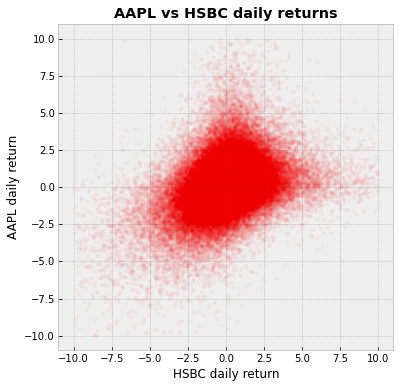

In [66]:
idx = (return_simulations['HSBC'] > -10) & (return_simulations['HSBC'] < 10)
idx = idx & (return_simulations['AAPL'] > -10) & (return_simulations['AAPL'] < 10)

x = return_simulations.loc[idx, 'HSBC']
y = return_simulations.loc[idx, 'AAPL']

fig = plt.figure()
fig.set_size_inches(6,6)

# fft_axes = fig.add_subplot(212)

plt.plot(x, y, "r.", alpha=0.03)
plt.xlabel("HSBC daily return")
plt.ylabel("AAPL daily return")
plt.title("AAPL vs HSBC daily returns", weight="bold")
plt.show()

Перейдем к бэктесту -- напишем еще пару функций для моделирования совместного распределения доходностей

In [67]:
def make_dummy_student_simulations(returns, n_samples):
    
    return_simulations = {}

    for col in returns.columns:
        t_df, t_mean, t_sigma = scipy.stats.t.fit(returns[col])
        return_simulations[col] = scipy.stats.t.rvs(t_df, loc=t_mean, scale=t_sigma, size=n_samples, random_state=42)

    return_simulations = pd.DataFrame(return_simulations)

    return return_simulations


def make_mult_normal_simulations(returns, n_samples):

    mean = np.mean(returns.values, axis=0)
    cov = np.cov(returns.values, rowvar=False)

    return_simulations = scipy.stats.multivariate_normal.rvs(mean=mean, cov=cov, size=n_samples, random_state=42)

    return_simulations = pd.DataFrame(return_simulations, columns=returns.columns)

    return return_simulations


Наконец, перейдем к самому бэктесту!

In [70]:
%%capture
alpha = 0.05

w = np.ones(shape=(returns.shape[1],)) / 3

# определяем параметры бэктеста
T = len(ret)
T_start = 100
estimation_window = 500
testing_window = T - estimation_window

VaR_curve_HS = []
VaR_curve_student = []
VaR_curve_multivariate_normal = []
VaR_curve_copula_t = []
VaR_curve_copula_garch = []

# в цикле проходимся по всем дням в выборке
for t in range(estimation_window+T_start, T):
    
    # фиксируем часть выборки
    current_estimation_sample = returns[t-estimation_window:t]
    
    # различными способами оцениваем ВаР и сохраняем значения
    protfolio = np.dot(current_estimation_sample.values, w)
    VaR_curve_HS.append(np.quantile(protfolio, alpha))
    
    student_simulation = make_dummy_student_simulations(current_estimation_sample, 10**4)
    VaR_curve_student.append(np.quantile(np.dot(student_simulation.values, w), alpha))
    
    multivariate_normal_simulation = make_mult_normal_simulations(current_estimation_sample, 10**4)
    VaR_curve_multivariate_normal.append(np.quantile(np.dot(multivariate_normal_simulation.values, w), alpha))
    
    copula_t_simulation = make_copula_simulation(current_estimation_sample, ClaytonCopula, n_samples=10**4, univariate_dist='t')
    VaR_curve_copula_t.append(np.quantile(np.dot(copula_t_simulation.values, w), alpha))
    
    copula_garch_simulation = make_copula_simulation(current_estimation_sample, ClaytonCopula,
                                                     n_samples=10**4, univariate_dist='garch')
    VaR_curve_copula_garch.append(np.quantile(np.dot(copula_garch_simulation.values, w), alpha))
    
    
VaR_curve_HS = pd.Series(VaR_curve_HS, index=ret[estimation_window+T_start:].index)
VaR_curve_student = pd.Series(VaR_curve_student, index=ret[estimation_window+T_start:].index)
VaR_curve_multivariate_normal = pd.Series(VaR_curve_multivariate_normal, index=ret[estimation_window+T_start:].index)

VaR_curve_copula_t = pd.Series(VaR_curve_copula_t, index=ret[estimation_window+T_start:].index)
VaR_curve_copula_garch = pd.Series(VaR_curve_copula_garch, index=ret[estimation_window+T_start:].index)

portfolio = np.dot(returns[estimation_window+T_start:].values, w)
portfolio = pd.Series(portfolio, index=ret[estimation_window+T_start:].index)

Посмотрим на график доходностей и на VaR кривые

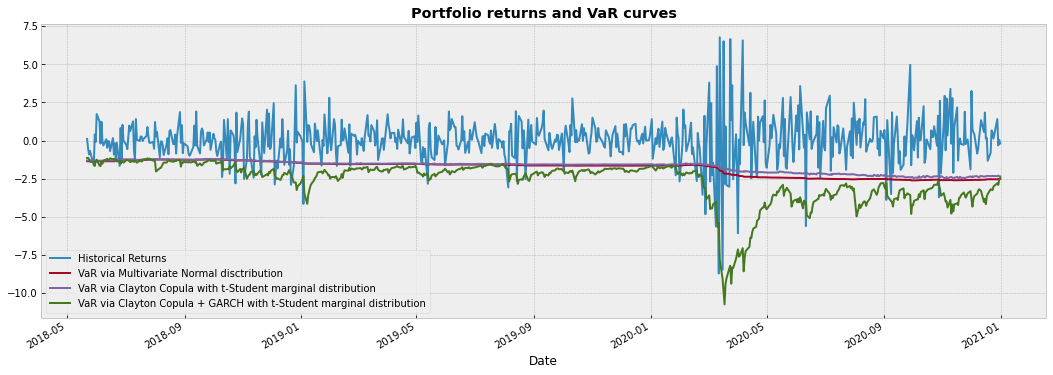

In [72]:
fig = plt.figure()
fig.set_size_inches(18,6)
portfolio.plot()
# VaR_curve_HS.plot()
# VaR_curve_student.plot()
VaR_curve_multivariate_normal.plot()
VaR_curve_copula_t.plot()
VaR_curve_copula_garch.plot()

plt.title("Portfolio returns and VaR curves", weight="bold")

plt.legend(['Historical Returns',
#             'VaR via Historical Simulation',
#             'VaR via t-Student distribution',
            'VaR via Multivariate Normal disctribution',
            'VaR via Clayton Copula with t-Student marginal distribution',
           'VaR via Clayton Copula + GARCH with t-Student marginal distribution'])
plt.show()

Проведем тесты Купика

In [73]:
kupiec_test(VaR_curve_HS, portfolio)

Количество наблюдений: 659
Желаемый уровень пробитий: 5.0%
Уровень пробитий в модели: 7.74%

p-value теста: 0.003

При уровне значимости 10.0% гипотеза гипотеза о
том, что эмпирическая и модельная частоты превышений фактическими
убытками границы VaR равны, отвергается


In [74]:
kupiec_test(VaR_curve_student, portfolio)

Количество наблюдений: 659
Желаемый уровень пробитий: 5.0%
Уровень пробитий в модели: 12.14%

p-value теста: 0.000

При уровне значимости 10.0% гипотеза гипотеза о
том, что эмпирическая и модельная частоты превышений фактическими
убытками границы VaR равны, отвергается


In [75]:
kupiec_test(VaR_curve_multivariate_normal, portfolio)

Количество наблюдений: 659
Желаемый уровень пробитий: 5.0%
Уровень пробитий в модели: 7.59%

p-value теста: 0.004

При уровне значимости 10.0% гипотеза гипотеза о
том, что эмпирическая и модельная частоты превышений фактическими
убытками границы VaR равны, отвергается


In [76]:
kupiec_test(VaR_curve_copula_t, portfolio)

Количество наблюдений: 659
Желаемый уровень пробитий: 5.0%
Уровень пробитий в модели: 8.19%

p-value теста: 0.001

При уровне значимости 10.0% гипотеза гипотеза о
том, что эмпирическая и модельная частоты превышений фактическими
убытками границы VaR равны, отвергается


In [77]:
kupiec_test(VaR_curve_copula_garch, portfolio)

Количество наблюдений: 659
Желаемый уровень пробитий: 5.0%
Уровень пробитий в модели: 3.95%

p-value теста: 0.198

При уровне значимости 10% гипотеза гипотеза о
том, что эмпирическая и модельная частоты превышений фактическими
убытками границы VaR равны, НЕ ОТВЕРГАЕТСЯ


Как мы видим, самое большое p-value, а также самый близкий к нужному нам уровень пробоев оказался как раз-таки у Copula-GARCH модели.


----------


Теперь перейдем к финальному этапу -- получению из всего это выгоды. Напишем функцию, которая подбирает веса портфеля таким образом, чтобы минимизировать его риск (то есть Value-at-Risk)

In [78]:
from scipy.optimize import minimize

# объявляем целевую функцию, которую мы будем минимизировать (поэтому в нужных местах ставим минусы)
def calculate_objective_function(weights, returns_simulation, alpha, objective_type):
    
    portfolio_simulation = np.dot(returns_simulation.values, weights)
    
    if objective_type == 'return':
        return -np.mean(portfolio_simulation)
    
    elif objective_type == 'var':
        return -np.quantile(portfolio_simulation, alpha)
    
    
def optimize(returns_simulation, alpha=0.05, objective_type='var'):
        
    init_guess = np.ones(shape=(returns.shape[1],)) / returns.shape[1]
    
    # вот тут можно поставить другие ограничения, например от -1 до 1, чтобы появилась возможность шортить -- продавать какие-то акции
    bounds = ((0.0, 1.0),) * returns.shape[1]
    
    weights = minimize(calculate_objective_function, init_guess,
                       args=(returns_simulation,alpha,objective_type), method='SLSQP',
                       options={'disp': False},
                       constraints=({'type': 'eq', 'fun': lambda inputs: 1.0 - np.sum(inputs)}),
                       bounds=bounds)
    
    return weights.x

Используем эту функцию, чтобы сравнить поведение трех портфелей -- с константными весами, и с весами, которые минимизируют VaR оцененный с помощью многомерного нормального распределения и Copula-GARCH

In [80]:
%%capture

alpha = 0.05

w = np.ones(shape=(returns.shape[1],)) / 3

T = len(ret)
T_start = 100
estimation_window = 250
testing_window = T - estimation_window

value = 100

value_const_weights = [value]
value_opt_weights_return = [value]
value_opt_weights_var = [value]
value_opt_weights_sharp = [value]
value_opt_weights_return_to_var = [value]
value_opt_weights_es_to_es = [value]

# делаем почти то же самое, что и в бэктесте ВаР
for t in range(estimation_window+T_start, T):
    
    real_returns = returns.iloc[t].values / 100
    
    value_new = np.dot(1+real_returns, w) * value_const_weights[-1]
    value_const_weights.append(value_new)
    
    # фиксируем тренировочное окно и делаем сэмплы
    current_estimation_sample = returns[t-estimation_window:t]
    copula_garch_simulation = make_copula_simulation(current_estimation_sample, ClaytonCopula, n_samples=10**4, univariate_dist='garch')
    
    # и различными способами оптимизируем веса в портфеле
    w_opt = optimize(copula_garch_simulation, objective_type='return')
    value_new = np.dot(1+real_returns, w_opt) * value_opt_weights_return[-1]
    value_opt_weights_return.append(value_new)
    
    w_opt = optimize(copula_garch_simulation, objective_type='var')
    value_new = np.dot(1+real_returns, w_opt) * value_opt_weights_var[-1]
    value_opt_weights_var.append(value_new)
    
#     w_opt = optimize(copula_garch_simulation, objective_type='sharp')
#     value_new = np.dot(1+real_returns, w_opt) * value_opt_weights_sharp[-1]
#     value_opt_weights_sharp.append(value_new)
    
#     w_opt = optimize(copula_garch_simulation, objective_type='return_to_var')
#     value_new = np.dot(1+real_returns, w_opt) * value_opt_weights_return_to_var[-1]
#     value_opt_weights_return_to_var.append(value_new)
    
#     w_opt = optimize(copula_garch_simulation, objective_type='es_to_es')
#     value_new = np.dot(1+real_returns, w_opt) * value_opt_weights_es_to_es[-1]
#     value_opt_weights_es_to_es.append(value_new)
    
value_const_weights.pop(0)
value_opt_weights_return.pop(0)
value_opt_weights_var.pop(0)
# value_opt_weights_sharp.pop(0)
# value_opt_weights_return_to_var.pop(0)
# value_opt_weights_es_to_es.pop(0)

value_const_weights = pd.Series(value_const_weights, index=ret[estimation_window+T_start:].index)
value_opt_weights_return = pd.Series(value_opt_weights_return, index=ret[estimation_window+T_start:].index)
value_opt_weights_var = pd.Series(value_opt_weights_var, index=ret[estimation_window+T_start:].index)
# value_opt_weights_sharp = pd.Series(value_opt_weights_sharp, index=ret[estimation_window+T_start:].index)
# value_opt_weights_return_to_var = pd.Series(value_opt_weights_return_to_var, index=ret[estimation_window+T_start:].index)
# value_opt_weights_es_to_es = pd.Series(value_opt_weights_es_to_es, index=ret[estimation_window+T_start:].index)

Построим график изменения стоимости нашего портфеля

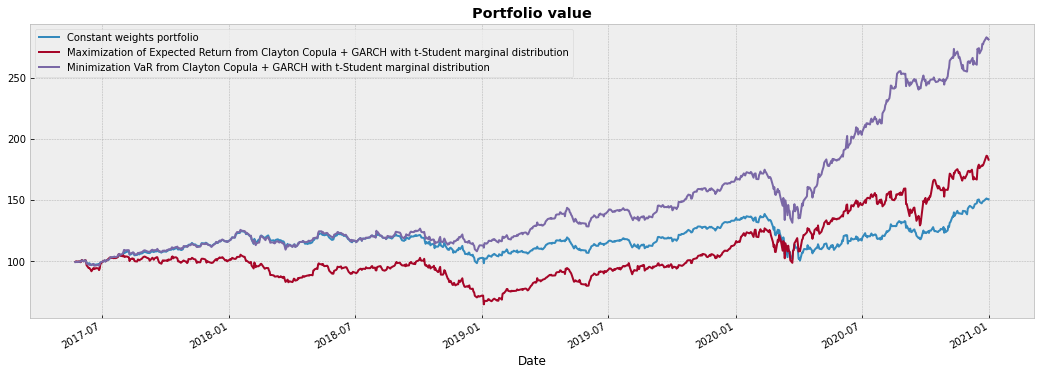

In [81]:
fig = plt.figure()
fig.set_size_inches(18,6)
value_const_weights.plot()
value_opt_weights_return.plot()
value_opt_weights_var.plot()
# value_opt_weights_sharp.plot()
# value_opt_weights_return_to_var.plot()
# value_opt_weights_es_to_es.plot()

plt.title("Portfolio value", weight="bold")

plt.legend(['Constant weights portfolio',
            'Maximization of Expected Return from Clayton Copula + GARCH with t-Student marginal distribution',
           'Minimization VaR from Clayton Copula + GARCH with t-Student marginal distribution'
#            'Maximization of Sharpe Ratio from Clayton Copula + GARCH with t-Student marginal distribution',
#            'Maximization of ER to VaR from Clayton Copula + GARCH with t-Student marginal distribution',
#            'Maximization of ES/ES from Clayton Copula + GARCH with t-Student marginal distribution'
           ])
plt.show()

Ура! Удивительно, но теория нас не подвела и самой "доходной" оказалась именно модель Copula-GARCH, которая учитывает как временную структуру временного ряда, так и нелинейные зависимости между его активами


Естественно, это не самая лучшая стратегия т.к. мы даже не смотрели на потенциальную доходность активов, а только минимизировали риск.

---------